### Imports

In [1]:
%matplotlib inline

import missingno as msno
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn-white')
import matplotlib.pyplot as plt
from cycler import cycler
from sklearn.pipeline import Pipeline
from pandas.plotting import scatter_matrix
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomTreesEmbedding, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.classifier import ClassBalance
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features.importances import FeatureImportances

### About the Data

I am using Home Mortgage Disclosure Act (HMDA) data for one year 2013,sample of 25,000 observations. https://www.consumerfinance.gov/data-research/hmda/explore 

Let's load the data:

### Data Ingestion and Wrangling

In [2]:
dataset = pd.read_csv("/Users/tamananaheeme/Desktop/fixtures/hmda2013sample.csv")
dataset.head(5)

,Unnamed: 0,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
0,0,117.730003,NaN,5180,63.189999,992,1215,79,61300,56,...,Male,NaN,NaN,NaN,NaN,White,Hispanic or Latino,National Credit Union Administration,NCUA,Loan originated
1,1,84.919998,NaN,4873,23.070000,1152,1882,128,54900,75,...,Female,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
2,2,42.509998,NaN,1715,58.480000,346,784,43,68700,38,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Application denied by financial institution
3,3,106.650002,NaN,4071,15.920000,1180,1472,100,67800,65,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Application denied by financial institution
4,4,88.489998,NaN,3001,16.790001,503,330,103,77800,151,...,Female,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Application approved but not accepted


### What missing values are there?

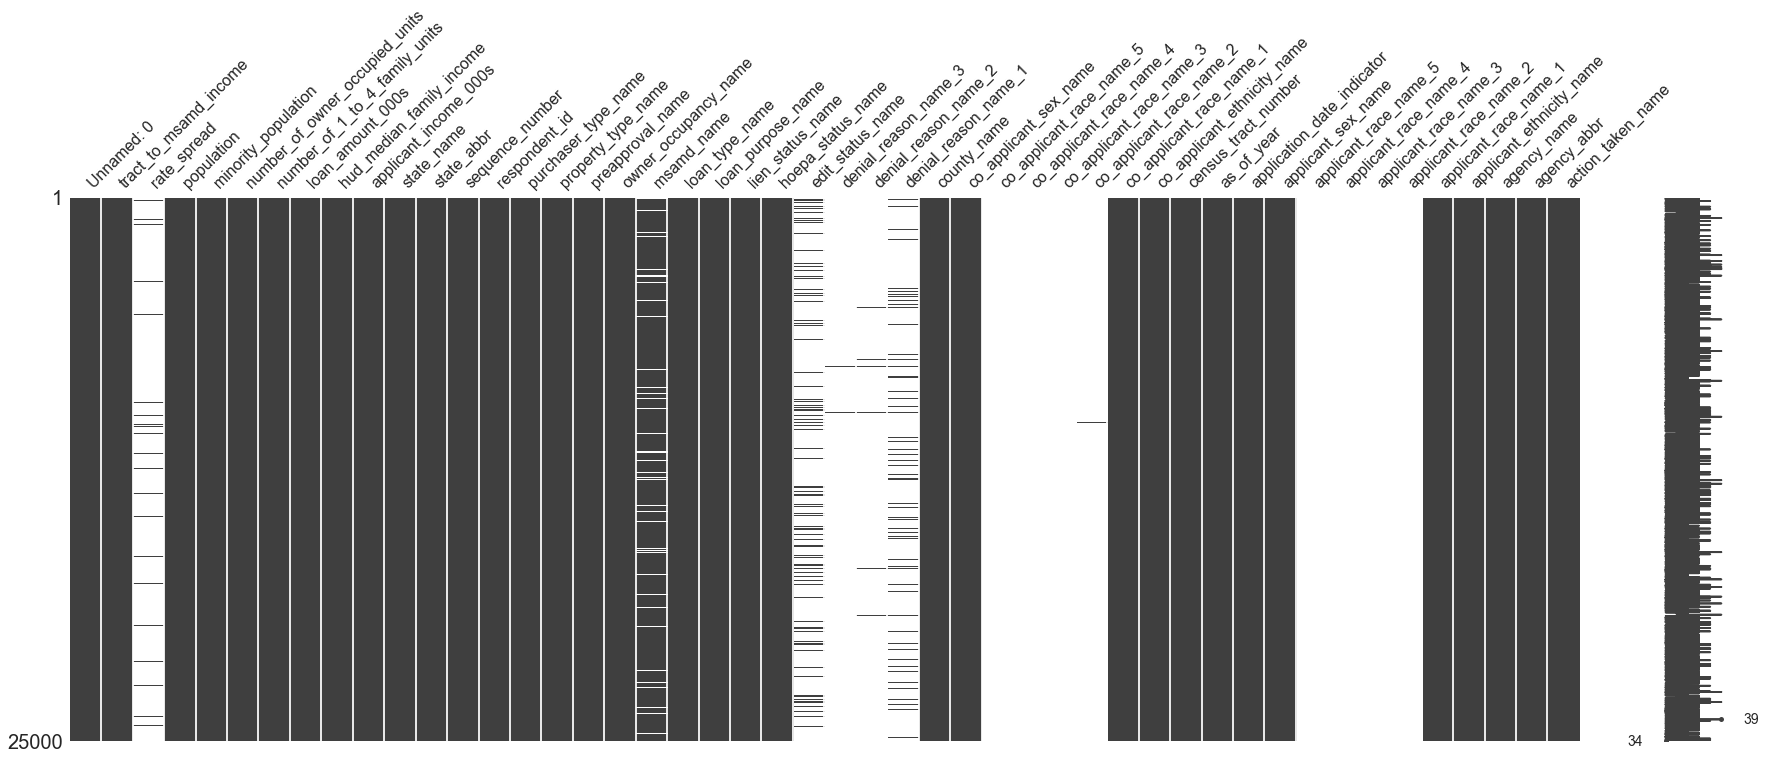

In [3]:
#Visualizing the location of missing values
msno.matrix(dataset, figsize = (30,10))

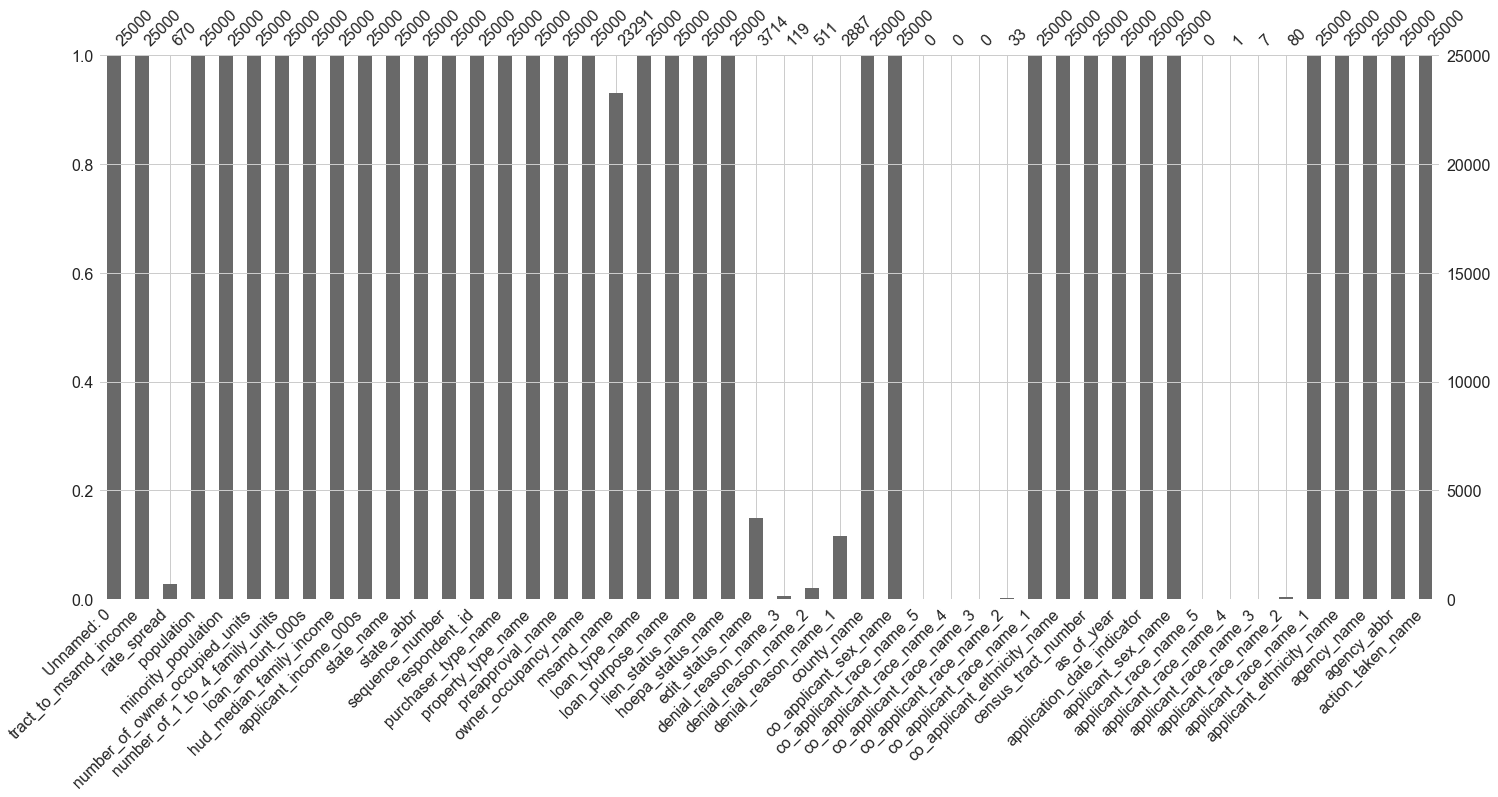

In [4]:
# Visualizing the number of missing values as a bar chart 
msno.bar(dataset) 

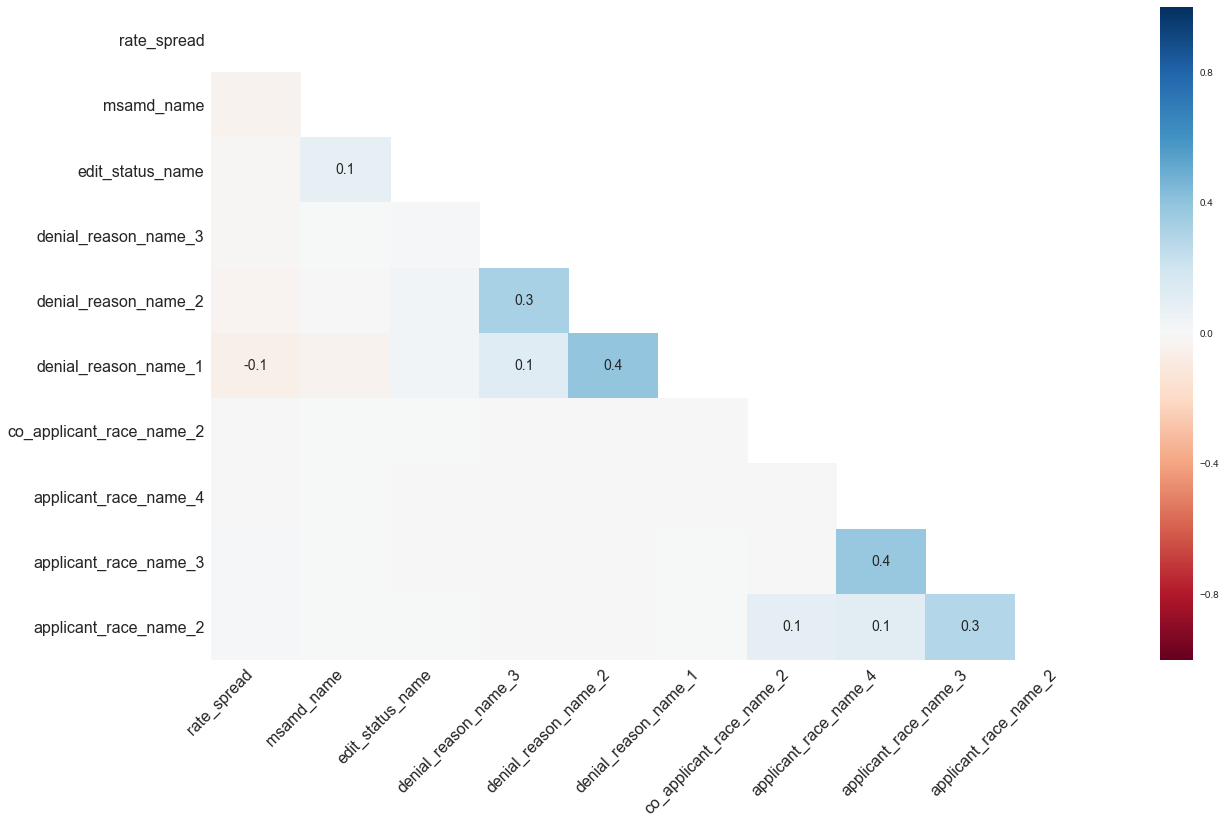

In [5]:
# Visualizing the correlation between the number of missing values in different columns as a heatmap 
msno.heatmap(dataset)

In [6]:
# Alternatively, we can see the number of missing values like this
dataset.isnull().sum()

Unnamed: 0                            0
tract_to_msamd_income                 0
rate_spread                       24330
population                            0
minority_population                   0
number_of_owner_occupied_units        0
number_of_1_to_4_family_units         0
loan_amount_000s                      0
hud_median_family_income              0
applicant_income_000s                 0
state_name                            0
state_abbr                            0
sequence_number                       0
respondent_id                         0
purchaser_type_name                   0
property_type_name                    0
preapproval_name                      0
owner_occupancy_name                  0
msamd_name                         1709
loan_type_name                        0
loan_purpose_name                     0
lien_status_name                      0
hoepa_status_name                     0
edit_status_name                  21286
denial_reason_name_3              24881


In [7]:
dataset['action_taken'] = dataset.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)
pd.crosstab(dataset['action_taken_name'],dataset['action_taken'], margins=True)

action_taken,0,1,All
action_taken_name,,,
Application approved but not accepted,1038,0,1038
Application denied by financial institution,3819,0,3819
Application withdrawn by applicant,2220,0,2220
File closed for incompleteness,753,0,753
Loan originated,0,14142,14142
Loan purchased by the institution,0,3028,3028
All,7830,17170,25000


In [8]:
# Getting basic statistical information for the target variable 
print(dataset.loc[:, 'action_taken'].mean())
print(dataset.loc[:, 'action_taken'].min())
print(dataset.loc[:, 'action_taken'].max())

0.6868
0
1


In [9]:
features = ['tract_to_msamd_income', 
    'population', 
    'minority_population', 
    'number_of_owner_occupied_units', 
    'number_of_1_to_4_family_units', 
    'loan_amount_000s', 
    'hud_median_family_income', 
    'applicant_income_000s',  
            
    ]
    

target = ['action_taken']


In [10]:
# Extracting our X and y data
X = dataset[features]
y = dataset[target]

print(X.shape, y.shape)

(25000, 8) (25000, 1)


In [11]:
# adding line of code to fill in missing values
X.fillna(X.mean(), inplace=True)

In [12]:
X.describe()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000
mean,117.659708,5330.473960,30.654104,1409.926200,1821.22132,216.371720,70200.892000,113.075120
std,42.180985,2393.740737,25.230882,694.167618,845.79343,210.610144,16193.235984,166.405326
min,13.040000,158.000000,1.000000,6.000000,1.00000,1.000000,16400.000000,1.000000
25%,90.489998,3803.000000,10.940000,929.750000,1275.75000,101.000000,60000.000000,52.000000
50%,110.830002,4972.000000,22.129999,1330.000000,1717.00000,169.000000,66000.000000,82.000000
75%,138.389999,6425.250000,43.320000,1780.000000,2261.00000,277.000000,77800.000000,129.000000
max,405.700012,33201.000000,99.870003,6886.000000,9464.00000,10000.000000,112200.000000,8814.000000


### Exploratory Analysis and Feature Selection

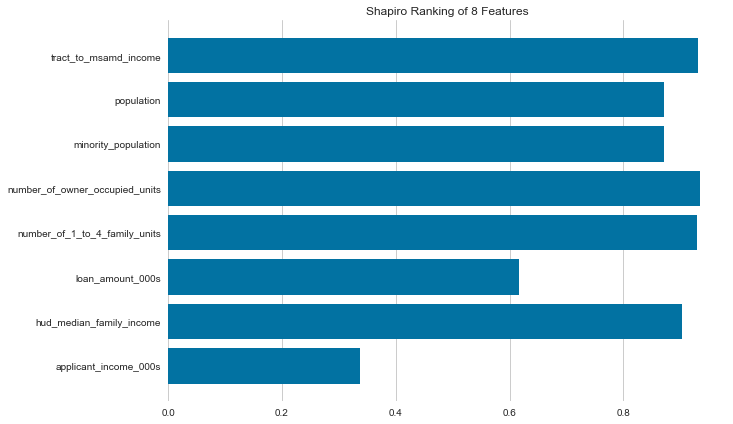

In [13]:
# Creating 1D visualizer with the Sharpiro feature ranking algorithm
fig, ax = plt.subplots(figsize=(10, 7))
visualizer = Rank1D(features=features, ax=ax, algorithm='shapiro')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

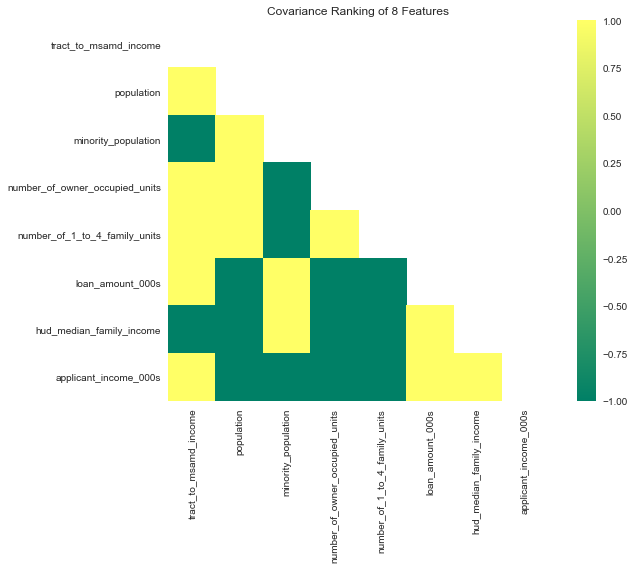

In [14]:
# Instantiate visualizer using covariance ranking algorithm
figsize=(10, 7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = Rank2D(features=features, ax=ax, algorithm='covariance', colormap='summer')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

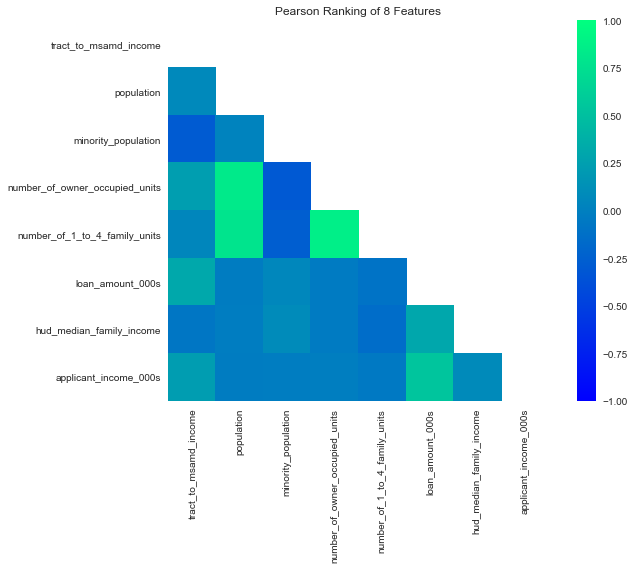

In [15]:
# Instantiate visualizer using Pearson ranking algorithm
figsize=(10, 7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = Rank2D(features=features, algorithm='pearson', colormap='winter')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

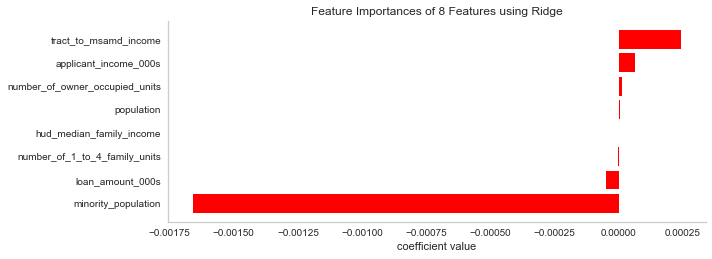

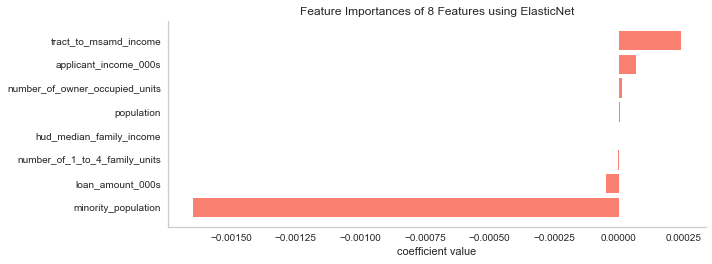

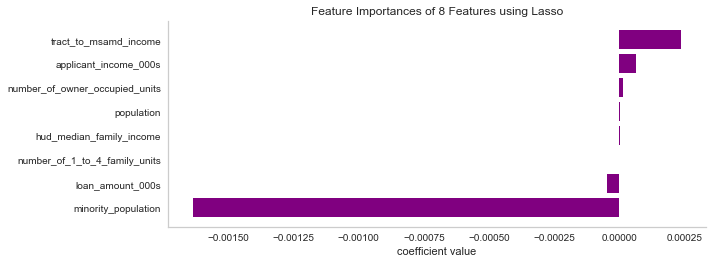

In [16]:
# Visualizing Ridge, Lasso and ElasticNet feature selection models side by side for comparison

# Ridge
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red'])
fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(311)
labels = features
viz = FeatureImportances(Ridge(alpha=0.1), ax=ax, labels=labels, relative=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

# ElasticNet
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['salmon'])
fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(312)
labels = features
viz = FeatureImportances(ElasticNet(alpha=0.01), ax=ax, labels=labels, relative=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

# Lasso 
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['purple'])
fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(313)
labels = features
viz = FeatureImportances(Lasso(alpha=0.01), ax=ax, labels=labels, relative=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

In [17]:
# Dropping features from X based on visual feature importance visualization
X = X.drop(['population','number_of_1_to_4_family_units','hud_median_family_income'], axis=1)

In [18]:
X.head()

,tract_to_msamd_income,minority_population,number_of_owner_occupied_units,loan_amount_000s,applicant_income_000s
0,117.730003,63.189999,992,79,56
1,84.919998,23.070000,1152,128,75
2,42.509998,58.480000,346,43,38
3,106.650002,15.920000,1180,100,65
4,88.489998,16.790001,503,103,151


In [19]:
print(X.columns)

Index(['tract_to_msamd_income', 'minority_population',
       'number_of_owner_occupied_units', 'loan_amount_000s',
       'applicant_income_000s'],
      dtype='object')


In [ ]:
# Encoding categorical features to binary 
X = pd.get_dummies(data=X, columns=['agency_name','applicant_race_name_5','county_name'])         

### Modeling and Evaluation


In [20]:
# Perform 80/20 training/test split
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=42)

In [25]:
# Creating a function to visualize estimators
    
def visual_model_selection(X, y, estimator):
    visualizer = ClassificationReport(estimator, classes=[1,0], cmap='PRGn')
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()


For model evaluation and selection we will be using Yellowbrick's Classification Report Visualizer, which displays the precision, recall, F1, and support scores for the model.

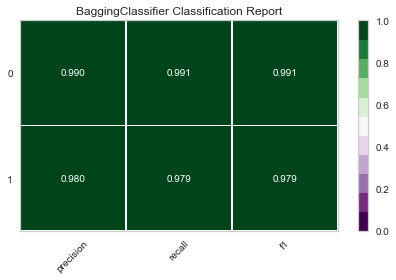

In [26]:
visual_model_selection(X, y, BaggingClassifier())

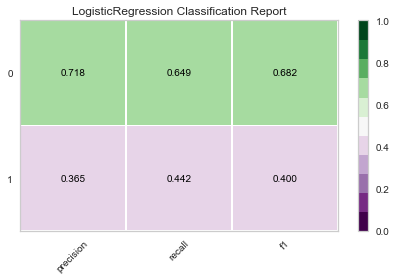

In [27]:
visual_model_selection(X, y, LogisticRegression(class_weight='balanced'))

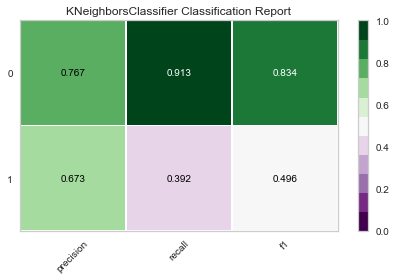

In [28]:
visual_model_selection(X, y, KNeighborsClassifier())

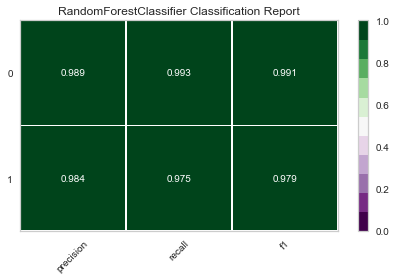

In [29]:
visual_model_selection(X, y, RandomForestClassifier(class_weight='balanced'))

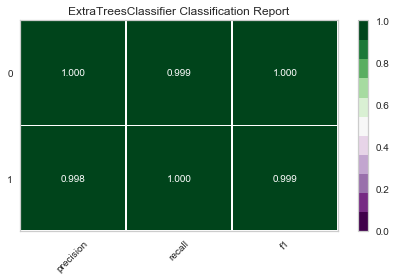

In [30]:
visual_model_selection(X, y, ExtraTreesClassifier(class_weight='balanced'))

### Model Optimization

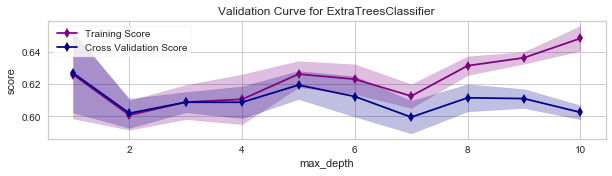

In [31]:
# Performing Hyperparameter tuning and Validation Curve

mpl.rcParams['axes.prop_cycle'] = cycler('color', ['purple', 'darkblue'])

fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(411)
viz = ValidationCurve(ExtraTreesClassifier(class_weight='balanced'), ax=ax, param_name="max_depth", param_range=np.arange(1, 11), cv=3, scoring="accuracy")

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()